In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Detect Face

In [2]:
# !unzip /content/drive/MyDrive/data/data_face_HUS.zip 

In [3]:
# !pip install facenet_pytorch

In [4]:
# !pip install mtcnn

In [5]:
# import os
# import cv2
# from mtcnn import MTCNN

# # Đường dẫn tới thư mục chứa các tệp ảnh cần detect khuôn mặt
# image_dir = '/content/data_face_HUS'

# # Đường dẫn tới thư mục lưu các tệp ảnh đã được detect khuôn mặt
# # output_dir = '/content/detect_face'

# # Tạo đối tượng detector MTCNN
# detector = MTCNN()

# for person_dir in os.listdir(image_dir):
#     person_path = os.path.join(image_dir, person_dir)
#     if os.path.isdir(person_path):
#         # Tạo thư mục đầu ra cho người này nếu chưa tồn tại
#         output_dir = os.path.join('/content/drive/MyDrive/detect_face', person_dir)
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)

#         # Lặp qua từng tệp ảnh trong thư mục
#         for filename in os.listdir(person_path):
#           if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
#             # Tạo đường dẫn đầy đủ tới tệp ảnh
#             img_path = os.path.join(person_path, filename)

#             # Đọc ảnh từ tệp
#             img = cv2.imread(img_path)

#             # Sử dụng MTCNN để detect khuôn mặt
#             result = detector.detect_faces(img)

#             # Lặp qua từng khuôn mặt đã detect được
#             for i, face in enumerate(result):
#                 # Lấy vị trí của khuôn mặt
#                 x, y, width, height = face['box']

#                 # Cắt ảnh ra để chỉ chứa khuôn mặt
#                 face_img = img[y:y+height, x:x+width]

#                 # Tạo tên tệp ảnh mới trong thư mục output
#                 new_filename = os.path.splitext(filename)[0] + f'_face_{i}.jpg'
#                 output_path = os.path.join(output_dir, new_filename)
                

#                 # Lưu ảnh khuôn mặt vào thư mục output
#                 cv2.imwrite(output_path, face_img)

#                 print(f'Đã detect khuôn mặt và lưu vào {output_path}')


Code

In [ ]:
!unzip /content/drive/MyDrive/data/detect_face_HUS.zip

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
import cv2
import os
import glob

# Đường dẫn đến thư mục chứa các thư mục con chứa ảnh của từng người
root_dir = '/content/detect_face'

X = []
y = []
label=0

# Duyệt qua tất cả các thư mục con
for person_dir in os.listdir(root_dir):
    person_path = os.path.join(root_dir, person_dir)
    # print(person_path)
    temp = person_path.split('/')
    # label = temp[-1].split("_")[0]
    
    # print(label)
    image_list = glob.glob(person_path + "/*")
    # print(len(image_list))
    for name in image_list:
        img = cv2.imread(name) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert ảnh thành gray
        img = cv2.resize(img, (50,50)) # chỉnh lại kích thước thành 50*50 pixel
        X.append((img))
        y.append(label)
    label+=1


In [9]:
len(X)

945

In [10]:
len(y)

945

In [11]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(945, 50, 50)
(945,)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(756, 50, 50) (189, 50, 50)
(756,) (189,)


In [24]:
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

inp = Input(shape=(50,50,1))
x = Conv2D(filters = 16, kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2,2))(x)


x = Conv2D(filters = 32, kernel_size=3, activation='relu')(inp)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

# x = Conv2D(filters = 64, kernel_size=3, activation='relu')(inp)
# x = MaxPooling2D(pool_size=(2,2))(x)
# x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(units=2)(x)

cnn = Model(inputs=inp, outputs=x)

img1 = Input(shape=(50,50,1))
img2 = Input(shape=(50,50,1))

f1 = cnn(img1)
f2 = cnn(img2)

d = K.sqrt(K.sum(K.square(f1-f2), axis=1, keepdims=True))

model = Model(inputs=[img1, img2], outputs=d)
model.summary()
cnn.summary()

def loss(y_true, y_pred):
  proba = K.exp(-K.square(y_pred))
  return -K.mean(y_true * K.log(proba) + (1-y_true)*K.log(1-proba))

def loss1(y_true, y_pred):
  return K.mean(y_true*K.square(y_pred) + (1-y_true) * K.square(K.maximum(1.0 - y_pred,0)))

model.compile(optimizer='adam',loss=loss1)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 model_2 (Functional)           (None, 2)            4719682     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 tf.math.subtract_1 (TFOpLambda  (None, 2)           0           ['model_2[0][0]',          

Batch size:  736
(50, 50, 1)
Pair label:  1.0


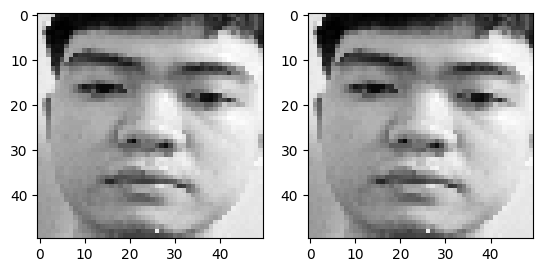

In [51]:
import numpy as np
from matplotlib import pyplot as plt

def generator(X,y,k=8):
  unique_labels = np.unique(y)

  while True: 
    X1 = []
    X2 = []
    y_batch =[]
    for label in unique_labels:
      label_idx = np.where(y==label)[0]
      other_labels = set(unique_labels) - {label}

      for i in range(k):
        i1 = np.random.choice(label_idx)
        i2 = np.random.choice(label_idx)

        # while i1==i2:
        #   i2 = np.random.choice(label_idx)
        
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(1.0)

        i1 = np.random.choice(label_idx)
        my_label = np.random.choice(list(other_labels))
        i2 = np.random.choice(list(np.where(y == my_label)[0]))
        X1.append(X[i1][:,:,None])
        X2.append(X[i2][:,:,None])
        y_batch.append(0.0)
    yield [np.array(X1)/255, np.array(X2)/255], np.array(y_batch)

for pair, y in generator(X_test, y_test):
  print('Batch size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print(pair[0][idx].shape)
  print('Pair label: ', y[idx])
  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(50,50), cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(50,50), cmap='gray')

  break



In [26]:
history = model.fit(generator(X_train,y_train,k=32),
                    steps_per_epoch=5,
                    epochs=100,
                    validation_data=generator(X_test,y_test,k=10),
                    validation_steps=5)

Epoch 1/100
5/5 [==============================] - 4s 479ms/step - loss: 0.4322 - val_loss: 0.2079
Epoch 2/100
5/5 [==============================] - 2s 421ms/step - loss: 0.2329 - val_loss: 0.1561
Epoch 3/100
5/5 [==============================] - 2s 404ms/step - loss: 0.1668 - val_loss: 0.1130
Epoch 4/100
5/5 [==============================] - 2s 407ms/step - loss: 0.1474 - val_loss: 0.1084
Epoch 5/100
5/5 [==============================] - 2s 391ms/step - loss: 0.1295 - val_loss: 0.1066
Epoch 6/100
5/5 [==============================] - 2s 517ms/step - loss: 0.1179 - val_loss: 0.1046
Epoch 7/100
5/5 [==============================] - 2s 547ms/step - loss: 0.1106 - val_loss: 0.1004
Epoch 8/100
5/5 [==============================] - 2s 427ms/step - loss: 0.1024 - val_loss: 0.0960
Epoch 9/100
5/5 [==============================] - 2s 409ms/step - loss: 0.0981 - val_loss: 0.0918
Epoch 10/100
5/5 [==============================] - 2s 358ms/step - loss: 0.0919 - val_loss: 0.0918
Epoch 11/

Text(0, 0.5, 'Loss')

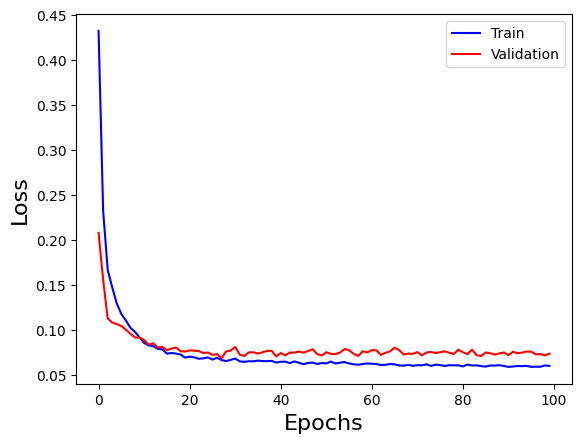

In [27]:
plt.plot(history.history['loss'], label='Train', c='b')
plt.plot(history.history['val_loss'], label='Validation', c='r')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)

23/23 [==============================] - 0s 2ms/step
Batch size:  736
Pair label:  1.0
Distance:  [0.07286218]
Distance by feature:  [0.07286206]


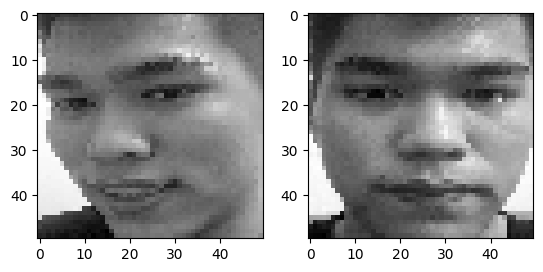

In [44]:
for pair, y in generator(X_test,y_test):
  y_pred = model.predict(pair)
  print('Batch size: ', len(y))
  idx = np.random.choice(range(len(y)))
  print('Pair label: ', y[idx])
  print('Distance: ', y_pred[idx])

  f1 = cnn(pair[0])
  f2 = cnn(pair[1])
  d=np.sqrt(np.sum((f1-f2)**2,axis=1,keepdims=True))
  print("Distance by feature: ", d[idx])

  plt.subplot(121)
  plt.imshow(pair[0][idx].reshape(50,50), cmap='gray')
  plt.subplot(122)
  plt.imshow(pair[1][idx].reshape(50,50), cmap='gray')
  break

6/6 [==============================] - 0s 2ms/step


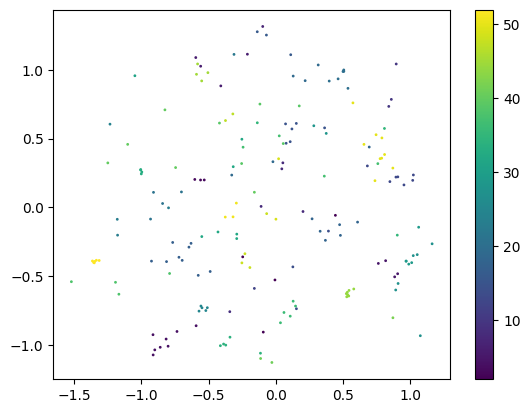

In [45]:
f = cnn.predict(X_test/255)
p = plt.scatter(f[:,0], f[:,1],c=y_test, s=1)
plt.colorbar(p)

In [46]:
cnn.save('cnn_loss1.h5')

6/6 [==============================] - 0s 3ms/step


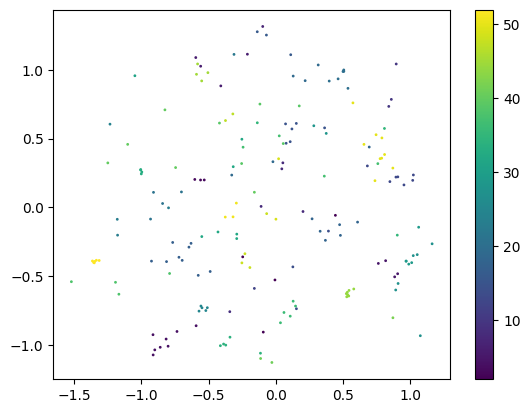

In [47]:
from tensorflow.keras.models import load_model
m = load_model('cnn_loss1.h5')

f1 = m.predict(X_test/255)
p=plt.scatter(f1[:,0], f1[:,1],c=y_test,s=1)
plt.colorbar(p)

In [48]:
i=0
y_true = []
y_pred = []
for pair, y in generator(X_test,y_test):
  f1=cnn(pair[0])
  f2=cnn(pair[1])
  d = np.sqrt(np.sum((f1-f2)**2, axis=1,keepdims=True))
  y_pred += list(d.ravel())
  y_true += list(y)
  i += 1
  if i>500:
    break

(array([0.05809725, 0.19423782, 0.35119499, 0.42041974, 0.5258652 ,
        0.57976128, 0.60636868, 0.63857764, 0.6718842 , 0.61302999,
        0.53226158, 0.44755693, 0.38495606, 0.32420911, 0.28019146,
        0.17887138, 0.1147941 , 0.03890812, 0.01442023, 0.0024223 ]),
 array([0.02043383, 0.16374078, 0.30704775, 0.45035473, 0.59366167,
        0.73696864, 0.88027561, 1.02358258, 1.16688955, 1.31019652,
        1.45350349, 1.59681046, 1.74011743, 1.88342428, 2.02673125,
        2.17003822, 2.31334519, 2.45665216, 2.59995914, 2.74326611,
        2.88657308]),
 <BarContainer object of 20 artists>)

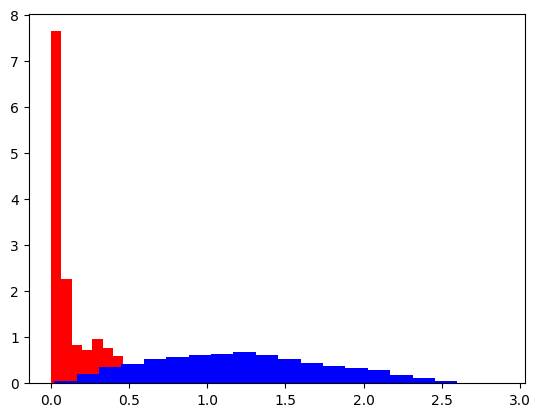

In [49]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

positive_distances = y_pred[y_true == 1]
negative_distances = y_pred[y_true == 0]

plt.hist(positive_distances,color='r', density=True,bins=20)
plt.hist(negative_distances, color='b',density=True,bins=20)

In [50]:
thresh = 0.5
y_pred_ = y_pred < thresh
y_pred_.astype('uint8')
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred_)) 


              precision    recall  f1-score   support

         0.0       0.92      0.89      0.90    184368
         1.0       0.90      0.92      0.91    184368

    accuracy                           0.91    368736
   macro avg       0.91      0.91      0.91    368736
weighted avg       0.91      0.91      0.91    368736

